<a href="https://colab.research.google.com/github/albert-h-wong/DS-Sprint-01-Dealing-With-Data/blob/master/LS_DS_114_Making_Data_backed_Assertions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science - Making Data-backed Assertions

This is, for many, the main point of data science - to create and support reasoned arguments based on evidence. It's not a topic to master in a day, but it is worth some focused time thinking about and structuring your approach to it.

## Lecture - generating a confounding variable

The prewatch material told a story about a hypothetical health condition where both the drug usage and overall health outcome were related to gender - thus making gender a confounding variable, obfuscating the possible relationship between the drug and the outcome.

Let's use Python to generate data that actually behaves in this fashion!

In [103]:
import random
dir(random)  # Reminding ourselves what we can do here

['BPF',
 'LOG4',
 'NV_MAGICCONST',
 'RECIP_BPF',
 'Random',
 'SG_MAGICCONST',
 'SystemRandom',
 'TWOPI',
 '_BuiltinMethodType',
 '_MethodType',
 '_Sequence',
 '_Set',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_acos',
 '_bisect',
 '_ceil',
 '_cos',
 '_e',
 '_exp',
 '_inst',
 '_itertools',
 '_log',
 '_pi',
 '_random',
 '_sha512',
 '_sin',
 '_sqrt',
 '_test',
 '_test_generator',
 '_urandom',
 '_warn',
 'betavariate',
 'choice',
 'choices',
 'expovariate',
 'gammavariate',
 'gauss',
 'getrandbits',
 'getstate',
 'lognormvariate',
 'normalvariate',
 'paretovariate',
 'randint',
 'random',
 'randrange',
 'sample',
 'seed',
 'setstate',
 'shuffle',
 'triangular',
 'uniform',
 'vonmisesvariate',
 'weibullvariate']

In [104]:
# Let's think of another scenario:
# We work for a company that sells accessories for mobile phones.
# They have an ecommerce site, and we are supposed to analyze logs
# to determine what sort of usage is related to purchases, and thus guide
# website development to encourage higher conversion.

# The hypothesis - users who spend longer on the site tend
# to spend more. Seems reasonable, no?

# But there's a confounding variable! If they're on a phone, they:
# a) Spend less time on the site, but
# b) Are more likely to be interested in the actual products!

# Let's use namedtuple to represent our data

from collections import namedtuple
# purchased and mobile are bools, time_on_site in seconds
User = namedtuple('User', ['purchased','time_on_site', 'mobile'])

example_user = User(False, 12, False)
print(example_user)

User(purchased=False, time_on_site=12, mobile=False)


In [105]:
# And now let's generate 1000 example users
# 750 mobile, 250 not (i.e. desktop)
# A desktop user has a base conversion likelihood of 10%
# And it goes up by 1% for each 15 seconds they spend on the site
# And they spend anywhere from 10 seconds to 10 minutes on the site (uniform)
# Mobile users spend on average half as much time on the site as desktop
# But have twice as much base likelihood of buying something

users = []

for _ in range(250):
  # Desktop users
  time_on_site = random.uniform(10, 600)
  purchased = random.random() < 0.1 + (time_on_site // 1500)
  users.append(User(purchased, time_on_site, False))
  
for _ in range(750):
  # Mobile users
  time_on_site = random.uniform(5, 300)
  purchased = random.random() < 0.2 + (time_on_site // 1500)
  users.append(User(purchased, time_on_site, True))
  
random.shuffle(users)
print(users[:10])

[User(purchased=False, time_on_site=274.00822025401044, mobile=False), User(purchased=False, time_on_site=262.1834213479704, mobile=True), User(purchased=False, time_on_site=385.8736215070939, mobile=False), User(purchased=False, time_on_site=241.57969140142356, mobile=True), User(purchased=False, time_on_site=285.6777069304402, mobile=False), User(purchased=True, time_on_site=248.87952448915885, mobile=True), User(purchased=False, time_on_site=196.23960267169466, mobile=True), User(purchased=False, time_on_site=88.67568507690049, mobile=False), User(purchased=False, time_on_site=236.55051794437074, mobile=True), User(purchased=False, time_on_site=288.35936115933566, mobile=True)]


In [106]:
# Let's put this in a dataframe so we can look at it more easily
import pandas as pd
user_data = pd.DataFrame(users)
user_data.head()

,purchased,time_on_site,mobile
0,False,274.008220,False
1,False,262.183421,True
2,False,385.873622,False
3,False,241.579691,True
4,False,285.677707,False


In [107]:
# Let's use crosstabulation to try to see what's going on
pd.crosstab(user_data['purchased'], user_data['time_on_site'])

time_on_site,5.127777049195306,5.188871977653075,5.479141443527356,6.671906509125487,7.5057542791954255,7.592619093556892,7.726016206245932,7.908135328578862,8.025647744814963,8.077487754167176,...,569.0197575227571,569.1699731241808,575.921316889027,577.7421814557782,578.8300368570381,581.1018331540491,581.1128988742262,584.0542624125129,590.4003913745973,594.4551314035737
purchased,,,,,,,,,,,,,,,,,,,,,
False,1,1,1,1,0,1,1,1,1,1,...,1,1,1,0,1,1,1,1,0,1
True,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0


In [108]:
# OK, that's not quite what we want
# Time is continuous! We need to put it in discrete buckets
# Pandas calls these bins, and pandas.cut helps make them

time_bins = pd.cut(user_data['time_on_site'], 5)  # 5 equal-sized bins
pd.crosstab(user_data['purchased'], time_bins)

time_on_site,"(4.538, 122.993]","(122.993, 240.859]","(240.859, 358.724]","(358.724, 476.59]","(476.59, 594.455]"
purchased,,,,,
False,280,287,176,46,46
True,65,56,36,3,5


In [109]:
# We can make this a bit clearer by normalizing (getting %)
pd.crosstab(user_data['purchased'], time_bins, normalize='columns')

time_on_site,"(4.538, 122.993]","(122.993, 240.859]","(240.859, 358.724]","(358.724, 476.59]","(476.59, 594.455]"
purchased,,,,,
False,0.811594,0.836735,0.830189,0.938776,0.901961
True,0.188406,0.163265,0.169811,0.061224,0.098039


In [110]:
# That seems counter to our hypothesis
# More time on the site seems to have fewer purchases

# But we know why, since we generated the data!
# Let's look at mobile and purchased
pd.crosstab(user_data['purchased'], user_data['mobile'], normalize='columns')

mobile,False,True
purchased,,
False,0.92,0.806667
True,0.08,0.193333


In [0]:
# Yep, mobile users are more likely to buy things
# But we're still not seeing the *whole* story until we look at all 3 at once

# Live/stretch goal - how can we do that?

## Assignment - what's going on here?

Consider the data in `persons.csv` (already prepared for you, in the repo for the week). It has four columns - a unique id, followed by age (in years), weight (in lbs), and exercise time (in minutes/week) of 1200 (hypothetical) people.

Try to figure out which variables are possibly related to each other, and which may be confounding relationships.

In [0]:
# Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [114]:
# Link the data to the notebook

persons_link = ('https://raw.githubusercontent.com/albert-h-wong/DS-Sprint-01-Dealing-With-Data/master/module4-databackedassertions/persons.csv')
!curl https://raw.githubusercontent.com/albert-h-wong/DS-Sprint-01-Dealing-With-Data/master/module4-databackedassertions/persons.csv

,age,weight,exercise_time
0,44,118,192
1,41,161,35
2,46,128,220
3,39,216,57
4,28,116,182
5,58,103,165
6,55,161,107
7,21,188,37
8,55,216,79
9,50,127,267
10,21,160,228
11,43,102,78
12,73,209,44
13,27,165,48
14,21,169,171
15,36,131,194
16,49,171,191
17,69,172,147
18,18,122,271
19,55,157,111
20,19,218,28
21,34,143,24
22,20,116,267
23,20,159,241
24,32,117,181
25,71,103,21
26,21,164,229
27,79,189,38
28,72,149,110
29,26,117,279
30,29,157,91
31,40,168,115
32,78,208,67
33,70,169,172
34,32,163,175
35,61,133,147
36,58,145,164
37,41,158,63
38,69,138,159
39,40,200,78
40,35,112,270
41,80,186,87
42,72,211,100
43,63,158,151
44,74,152,83
45,52,140,187
46,71,136,75
47,27,192,6
48,23,120,264
49,49,149,171
50,61,193,71
51,49,140,280
52,50,109,194
53,60,134,162
54,70,244,18
55,34,101,182
56,60,170,182
57,47,200,105
58,53,122,259
59,69,153,43
60,31,109,164
61,68,109,25
62,41,128,225
63,28,142,215
64,64,154,249
65,31,231,2
66,32,186,187
67,72,207,2
68,55,130,300
69,40,137,238
70,58,113,276
71,79,160,73
72,58

In [115]:
# Read the data and and preview it

persons_data = pd.read_csv(persons_link)
persons_data.head(15)

,Unnamed: 0,age,weight,exercise_time
0,0,44,118,192
1,1,41,161,35
2,2,46,128,220
3,3,39,216,57
4,4,28,116,182
5,5,58,103,165
6,6,55,161,107
7,7,21,188,37
8,8,55,216,79
9,9,50,127,267


In [116]:
# Check out the instances and attributes of the data
persons_data.shape

(1200, 4)

In [117]:
# Re-label the columns and check out the summary statistics

labels = ['identifier','age','weight','exercise_time']
persons_data.columns = labels
persons_data.describe()

,identifier,age,weight,exercise_time
count,1200.000000,1200.000000,1200.000000,1200.000000
mean,599.500000,48.396667,153.540833,134.910833
std,346.554469,18.166802,35.132182,85.548895
min,0.000000,18.000000,100.000000,0.000000
25%,299.750000,33.000000,125.000000,65.000000
50%,599.500000,48.000000,149.000000,122.000000
75%,899.250000,64.000000,180.250000,206.000000
max,1199.000000,80.000000,246.000000,300.000000


In [118]:
# Identify the variable data types
persons_data.dtypes

identifier       int64
age              int64
weight           int64
exercise_time    int64
dtype: object

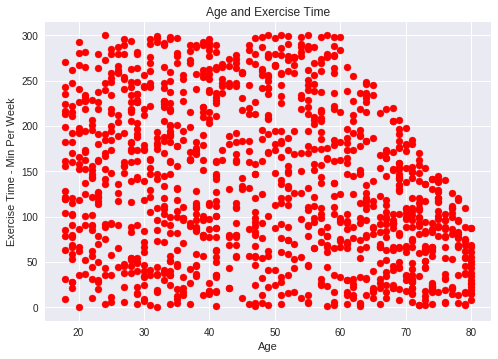

In [119]:
# There is a slight trend of decreasing exercise activity as individuals age
# over 60 years old

plt.scatter(persons_data['age'], persons_data['exercise_time'], color='red')
plt.xlabel('Age')
plt.ylabel('Exercise Time - Min Per Week')
plt.title("Age and Exercise Time")
plt.show()

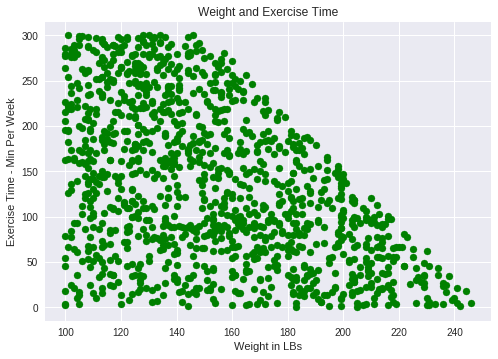

In [120]:
# Weight is clearly higher in individuals that exercise less frequently

plt.scatter(persons_data['weight'], persons_data['exercise_time'], color='green')
plt.xlabel('Weight in LBs')
plt.ylabel('Exercise Time - Min Per Week')
plt.title("Weight and Exercise Time")
plt.show()

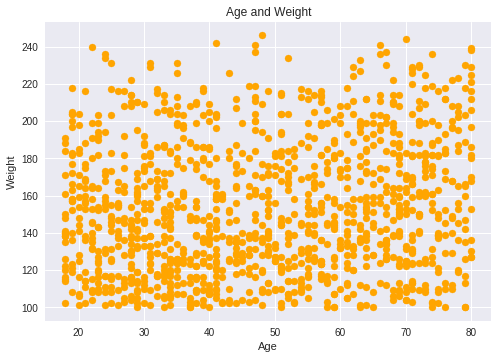

In [121]:
# Very little relationship is observed between age and weight when
# observing the entire data set

plt.scatter(persons_data['age'], persons_data['weight'], color='orange')
plt.xlabel('Age')
plt.ylabel('Weight')
plt.title("Age and Weight")
plt.show()

In [0]:
# Create bins to better analyze any observations in groups

age_bins = pd.cut(persons_data['age'], 5)  # 5 equal-sized bins
weight_bins = pd.cut(persons_data['weight'], 5)
exercise_bins = pd.cut(persons_data['exercise_time'], 5)


In [123]:
# Create an ordinal variable in the dataframe for age to be included as a 3rd 
# dimension of the scatter plot.

def f(x):
  # Assigned a value based on threshold from binning
    val = []
    for i in x:
      if i > 67:
        val.append(5)
      elif i > 55:
        val.append(4)
      elif i > 42:
        val.append(3)
      elif i > 30:
        val.append(2)
      else:
        val.append(1)
       
    return val
  
f(persons_data.age)

[3,
 2,
 3,
 2,
 1,
 4,
 3,
 1,
 3,
 3,
 1,
 3,
 5,
 1,
 1,
 2,
 3,
 5,
 1,
 3,
 1,
 2,
 1,
 1,
 2,
 5,
 1,
 5,
 5,
 1,
 1,
 2,
 5,
 5,
 2,
 4,
 4,
 2,
 5,
 2,
 2,
 5,
 5,
 4,
 5,
 3,
 5,
 1,
 1,
 3,
 4,
 3,
 3,
 4,
 5,
 2,
 4,
 3,
 3,
 5,
 2,
 5,
 2,
 1,
 4,
 2,
 2,
 5,
 3,
 2,
 4,
 5,
 4,
 2,
 5,
 4,
 4,
 5,
 3,
 5,
 5,
 1,
 1,
 1,
 2,
 3,
 5,
 5,
 3,
 2,
 2,
 4,
 1,
 2,
 2,
 1,
 2,
 5,
 3,
 5,
 4,
 1,
 2,
 5,
 3,
 3,
 3,
 4,
 2,
 4,
 1,
 5,
 2,
 2,
 4,
 5,
 5,
 4,
 3,
 2,
 5,
 2,
 1,
 5,
 2,
 5,
 4,
 5,
 2,
 5,
 1,
 4,
 4,
 1,
 1,
 1,
 1,
 4,
 3,
 1,
 4,
 1,
 4,
 1,
 2,
 1,
 2,
 3,
 1,
 1,
 1,
 2,
 4,
 2,
 2,
 2,
 1,
 5,
 5,
 5,
 2,
 4,
 3,
 2,
 3,
 5,
 3,
 3,
 3,
 4,
 1,
 1,
 4,
 5,
 3,
 1,
 4,
 5,
 4,
 3,
 3,
 5,
 2,
 2,
 2,
 4,
 3,
 4,
 2,
 1,
 2,
 3,
 3,
 5,
 1,
 5,
 2,
 5,
 3,
 1,
 5,
 2,
 5,
 1,
 2,
 5,
 5,
 4,
 3,
 1,
 4,
 4,
 5,
 4,
 3,
 4,
 5,
 4,
 4,
 4,
 5,
 1,
 5,
 3,
 1,
 3,
 4,
 5,
 1,
 2,
 1,
 2,
 4,
 3,
 2,
 1,
 5,
 5,
 1,
 4,
 3,
 5,
 3,
 2,
 5,
 4,
 2,
 1,
 5,
 2,


In [124]:
# Continued...create an ordinal variable for age to be included as a 3rd dimension of the
# scatter plot.

age_range = f(persons_data.age)
persons_data = persons_data.assign(age_range=age_range)
print(persons_data.age_range)


0       3
1       2
2       3
3       2
4       1
5       4
6       3
7       1
8       3
9       3
10      1
11      3
12      5
13      1
14      1
15      2
16      3
17      5
18      1
19      3
20      1
21      2
22      1
23      1
24      2
25      5
26      1
27      5
28      5
29      1
       ..
1170    1
1171    4
1172    1
1173    5
1174    1
1175    4
1176    4
1177    2
1178    4
1179    5
1180    2
1181    2
1182    3
1183    5
1184    4
1185    2
1186    4
1187    3
1188    5
1189    2
1190    5
1191    1
1192    3
1193    2
1194    4
1195    3
1196    1
1197    1
1198    1
1199    4
Name: age_range, Length: 1200, dtype: int64


In [125]:
# The crosstab of median exercise time in the bins uncovers a counterintuitive 
# observation compared to the rest of the data in that younger individuals in the
# heaviest bin exercises even less than older peers within the same weight cohort

pd.crosstab(age_bins, weight_bins, values=persons_data.exercise_time, aggfunc='median')


weight,"(99.854, 129.2]","(129.2, 158.4]","(158.4, 187.6]","(187.6, 216.8]","(216.8, 246.0]"
age,,,,,
"(17.938, 30.4]",195.0,181.5,136.0,60.0,11.0
"(30.4, 42.8]",200.5,196.5,113.0,55.0,13.0
"(42.8, 55.2]",234.5,201.0,120.0,84.0,30.5
"(55.2, 67.6]",165.0,165.0,95.0,74.5,22.0
"(67.6, 80.0]",94.5,89.5,85.0,72.5,47.0


In [126]:
# The crosstab counts within the bins helps gives some perspective on sample size
# in the segments in case any insight on effect should be tempered by the lack 
# of power.

pd.crosstab(age_bins, [weight_bins, exercise_bins])


weight         (99.854, 129.2]                                              \
exercise_time     (-0.3, 60.0] (60.0, 120.0] (120.0, 180.0] (180.0, 240.0]   
age                                                                          
(17.938, 30.4]              10             9             17             19   
(30.4, 42.8]                 8            19             19             25   
(42.8, 55.2]                 7             6              9             18   
(55.2, 67.6]                 7            10             13             12   
(67.6, 80.0]                21            21             13              5   

weight                        (129.2, 158.4]                               \
exercise_time  (240.0, 300.0]   (-0.3, 60.0] (60.0, 120.0] (120.0, 180.0]   
age                                                                         
(17.938, 30.4]             25              7            15             20   
(30.4, 42.8]               33             10             8              8   
(42.8, 55.2]               38              7             9             13   
(55.2, 67.6]               11              6            20             14   
(67.6, 80.0]                0             14            24             12   

weight                                            ...       (187.6, 216.8]  \
exercise_time  (180.0, 240.0] (240.0, 300.0]      ...         (-0.3, 60.0]   
age                                               ...                        
(17.938, 30.4]             29             15      ...                   17   
(30.4, 42.8]               15             21      ...                   17   
(42.8, 55.2]                7             26      ...                    9   
(55.2, 67.6]               19             12      ...                   15   
(67.6, 80.0]                4              0      ...                   18   

weight                                                                     \
exercise_time  (60.0, 120.0] (120.0, 180.0] (180.0, 240.0] (240.0, 300.0]   
age                                                                         
(17.938, 30.4]            10              7              0              0   
(30.4, 42.8]              12              2              0              0   
(42.8, 55.2]              12              5              0              0   
(55.2, 67.6]              21              7              1              0   
(67.6, 80.0]              18              8              0              0   

weight         (216.8, 246.0]                                              \
exercise_time    (-0.3, 60.0] (60.0, 120.0] (120.0, 180.0] (180.0, 240.0]   
age                                                                         
(17.938, 30.4]              7             0              0              0   
(30.4, 42.8]                7             0              0              0   
(42.8, 55.2]                7             1              0              0   
(55.2, 67.6]                8             1              0              0   
(67.6, 80.0]               15             7              0              0   

weight                         
exercise_time  (240.0, 300.0]  
age                            
(17.938, 30.4]              0  
(30.4, 42.8]                0  
(42.8, 55.2]                0  
(55.2, 67.6]                0  
(67.6, 80.0]                0  

[5 rows x 25 columns]

In [127]:
# The normalized crosstabs provides a sense of concentration within the bins. No major
# insights were gained.

pd.crosstab(age_bins, [weight_bins, exercise_bins], normalize='columns')


weight         (99.854, 129.2]                                              \
exercise_time     (-0.3, 60.0] (60.0, 120.0] (120.0, 180.0] (180.0, 240.0]   
age                                                                          
(17.938, 30.4]        0.188679      0.138462       0.239437       0.240506   
(30.4, 42.8]          0.150943      0.292308       0.267606       0.316456   
(42.8, 55.2]          0.132075      0.092308       0.126761       0.227848   
(55.2, 67.6]          0.132075      0.153846       0.183099       0.151899   
(67.6, 80.0]          0.396226      0.323077       0.183099       0.063291   

weight                        (129.2, 158.4]                               \
exercise_time  (240.0, 300.0]   (-0.3, 60.0] (60.0, 120.0] (120.0, 180.0]   
age                                                                         
(17.938, 30.4]       0.233645       0.159091      0.197368       0.298507   
(30.4, 42.8]         0.308411       0.227273      0.105263       0.119403   
(42.8, 55.2]         0.355140       0.159091      0.118421       0.194030   
(55.2, 67.6]         0.102804       0.136364      0.263158       0.208955   
(67.6, 80.0]         0.000000       0.318182      0.315789       0.179104   

weight                                            ...       (187.6, 216.8]  \
exercise_time  (180.0, 240.0] (240.0, 300.0]      ...         (-0.3, 60.0]   
age                                               ...                        
(17.938, 30.4]       0.391892       0.202703      ...             0.223684   
(30.4, 42.8]         0.202703       0.283784      ...             0.223684   
(42.8, 55.2]         0.094595       0.351351      ...             0.118421   
(55.2, 67.6]         0.256757       0.162162      ...             0.197368   
(67.6, 80.0]         0.054054       0.000000      ...             0.236842   

weight                                                                     \
exercise_time  (60.0, 120.0] (120.0, 180.0] (180.0, 240.0] (240.0, 300.0]   
age                                                                         
(17.938, 30.4]      0.136986       0.241379            0.0            0.0   
(30.4, 42.8]        0.164384       0.068966            0.0            0.0   
(42.8, 55.2]        0.164384       0.172414            0.0            0.0   
(55.2, 67.6]        0.287671       0.241379            1.0            0.0   
(67.6, 80.0]        0.246575       0.275862            0.0            0.0   

weight         (216.8, 246.0]                                              \
exercise_time    (-0.3, 60.0] (60.0, 120.0] (120.0, 180.0] (180.0, 240.0]   
age                                                                         
(17.938, 30.4]       0.159091      0.000000            0.0            0.0   
(30.4, 42.8]         0.159091      0.000000            0.0            0.0   
(42.8, 55.2]         0.159091      0.111111            0.0            0.0   
(55.2, 67.6]         0.181818      0.111111            0.0            0.0   
(67.6, 80.0]         0.340909      0.777778            0.0            0.0   

weight                         
exercise_time  (240.0, 300.0]  
age                            
(17.938, 30.4]            0.0  
(30.4, 42.8]              0.0  
(42.8, 55.2]              0.0  
(55.2, 67.6]              0.0  
(67.6, 80.0]              0.0  

[5 rows x 25 columns]

In [128]:
# The crosstab helps demonstrate the general lower median weight for individuals that
# exercise more frequently per week while also showing how weight increases from young 
# adult to middle age but then reverses with aging thereafter.

pd.crosstab(age_bins, exercise_bins, values=persons_data.weight, aggfunc='median')


exercise_time,"(-0.3, 60.0]","(60.0, 120.0]","(120.0, 180.0]","(180.0, 240.0]","(240.0, 300.0]"
age,,,,,
"(17.938, 30.4]",181.5,157.5,144.0,142.0,128.0
"(30.4, 42.8]",186.0,160.0,137.5,129.0,127.0
"(42.8, 55.2]",181.0,171.5,151.0,129.0,127.0
"(55.2, 67.6]",188.0,171.0,139.5,141.0,133.0
"(67.6, 80.0]",170.0,161.5,154.0,127.0,NaN


In [0]:
median_weights = pd.crosstab(exercise_bins, age_bins, values=persons_data.weight, aggfunc='median')

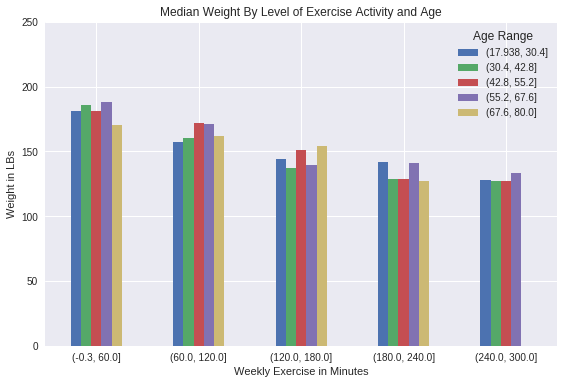

In [165]:
# The bar chart below helps illustrate that in general weight is higher in
# individuals that do not exercise regularly each week by observing the group of
# bars compared to the other groups from left to right. However you can also 
# see that within each group of bars the relative difference in weight is not as
# significant. Median weight was calculated to offset any potential outlier data
# points with high or low weights that could skew the group segmented in smaller
# sample sizes.

ct_persons = pd.crosstab(age_bins, [exercise_bins, weight_bins])

median_weights.plot(kind='bar');
plt.xlabel('Weekly Exercise in Minutes')
plt.xticks(rotation=0)
plt.ylabel('Weight in LBs')
plt.ylim([0, 250])
plt.title("Median Weight By Level of Exercise Activity and Age")
plt.legend(title = 'Age Range')

 
plt.tight_layout()


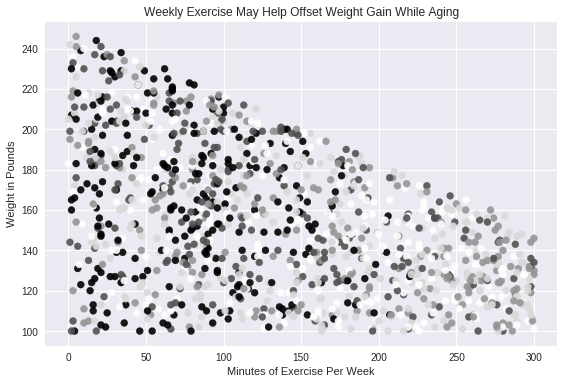

In [135]:
# The scatter plot below shows the general lower weights of individuals that tend
# to exercise more a weekly basis. By also adding in the coloring of the marker
# by age segementation you can also see the higher concentration of heavier individuals
# in their middle ages (black or darkest shading of the markers).

color = persons_data.age_range

fig, ax = plt.subplots()
ax.scatter(persons_data['exercise_time'], persons_data['weight'], c=color, alpha=0.9)

ax.set_xlabel('Minutes of Exercise Per Week')
ax.set_ylabel('Weight in Pounds')
ax.set_title('Weekly Exercise May Help Offset Weight Gain While Aging')

ax.grid(True)
fig.tight_layout()


plt.show()

### Assignment questions

After you've worked on some code, answer the following questions in this text block:

1.  What are the variable types in the data?

The variable types in the data are all integers as indicated further up above in the datatype code block.

2.  What are the relationships between the variables?

The three main variables are age, exercise time and weight. The data set is fairly limited to draw any conclusions but there is likely general correlation between all three variables. It is more reasonable to comment on the observations reported in the study such as weight is generally higher in individuals that do not spend as much time exercising on a weekly basis. Older people in the data also tend to exercise less than the younger demographic as well. However there is a weak relationship in the data between age and weight which could indicate age may not be a high impact factor to weight gain.

3.  Which relationships are "real", and which spurious?

Exercising and weight is likely to be a real relationship. However since the data is only a static measurement of the individuals, there is still some level of uncertainty to infer that exercising is a major factor in reducing weight. We would need to be able to measure the weight of people before and after in a time series to see the effects. We would also need to have a control group or counterfactual to measure against for a more precise isolation of the effect size. Age and weight is more likely to be a spurious relationship when observed through a scale of age from 18-80. However through binning you can observe there is some relationship that shows weight gain from 18 to 55 before it reverses and weight declines from aging. 

## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub.

- [Spurious Correlations](http://tylervigen.com/spurious-correlations)
- [NIH on controlling for confounding variables](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4017459/)

Stretch goals:

- Produce your own plot inspierd by the Spurious Correlation visualizations (and consider writing a blog post about it - both the content and how you made it)
- Pick one of the techniques that NIH highlights for confounding variables - we'll be going into many of them later, but see if you can find which Python modules may help (hint - check scikit-learn)